In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, joint_plot, plot_alert_rate, plot_confusion_matrix, evaluate_all_outcomes, alert_rate_curve
from hyperparameter_tuning import tune_lgbm, tune_logisticregression
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
from dataset import SCIData, SCICols
%aimport utils.evaluation, hyperparameter_tuning, dataset, utils.data_profiling

In [3]:
class Notebook:
    IMAGE_DIR = "images/clinical_models_2"
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 30
    HYPERPARAMETER_TRIALS = 1000
    HYPERPARAMETER_NJOBS = -1

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 9999

    MODELS = {}
    EXPLAINERS = {}
    Y_PREDS = {}


try:
    os.makedirs(Notebook.IMAGE_DIR)
except FileExistsError:
    pass


In [4]:
from sklearn.model_selection import train_test_split

sci = (
    SCIData(SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime"))
    .mandate(SCICols.news_data_raw)
  #  .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)
sci = SCIData(sci[~sci.AdmittedAfterAEC].copy())

scii = sci.derive_critical_event(within=1, return_subcols=True)

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii.drop(["DiedWithinThreshold", "CriticalCare"], axis=1),
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
drop_exclusive_cols(sci_train, sci_test)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

test_set_n_days = (
    sci_test.AdmissionDateTime.max() - sci_test.AdmissionDateTime.min()
).days



In [5]:
(X_train, y_train), (X_test, y_test) = (
    sci_train.omit_redundant()
    .raw_news()
    .impute_news()
    .impute_blood()
    .xy(outcome="CriticalEvent", dropna=False, ordinal_encoding=True, fillna=True),
    sci_test.omit_redundant()
    .raw_news()
    .impute_news()
    .impute_blood()
    .xy(outcome="CriticalEvent", dropna=False, ordinal_encoding=True, fillna=True),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

(X_train_lgbm, _), (X_test_lgbm, _) = (
    sci_train.omit_redundant().raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False, ordinal_encoding=True
    ),
    sci_test.omit_redundant().raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False, ordinal_encoding=True
    ),
)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_cat, _), (X_test_cat, _) = (
    sci_train.omit_redundant().raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False
    ),
    sci_test.omit_redundant().raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False
    ),
)

(X_train_news, _), (X_test_news, _) = (
    sci_train.omit_redundant()
    .impute_news()
    .impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=True,
    ),
    sci_test.omit_redundant()
    .impute_news()
    .impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=True,
    ),
)


In [6]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


In [7]:
def benchmark(y_pred, y_pred_proba, Xtest, modelkey, filekey, tuning=False):
    evaluate_all_outcomes(
        y_test,
        y_test_mortality,
        y_test_criticalcare,
        y_pred,
        y_pred_proba,
        modelkey,
        n_resamples=Notebook.EVAL_N_RESAMPLES,
        save=f"{Notebook.IMAGE_DIR}/eval_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )
    plot_confusion_matrix(
        y_test,
        y_pred,
        plot_title=modelkey,
        save=f"{Notebook.IMAGE_DIR}/matrix_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )

    if not tuning:
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)
    else:
        modelkey = f"{modelkey} (tuned)"
        threshold = get_threshold(y_test, model.predict_proba(Xtest.to_numpy())[:, 1])
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        evaluate_all_outcomes(
            y_test,
            y_test_mortality,
            y_test_criticalcare,
            y_pred,
            y_pred_proba,
            modelkey,
            n_resamples=Notebook.EVAL_N_RESAMPLES,
            save=f"{Notebook.IMAGE_DIR}/eval_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        plot_confusion_matrix(
            y_test,
            y_pred,
            plot_title=modelkey,
            save=f"{Notebook.IMAGE_DIR}/matrix_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)


# Models

## Baseline (NEWS)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Baseline (NEWS),,,,,,,
Critical event,0.979622,0.133240,0.341727,0.191726,0.260274,0.828473,0.828 (0.799-0.857)
Mortality only,0.982853,0.110799,0.663866,0.189904,0.332212,0.930648,0.931 (0.897-0.960)
Critical care,0.978732,0.035063,0.144509,0.056433,0.088968,0.769344,0.769 (0.730-0.808)


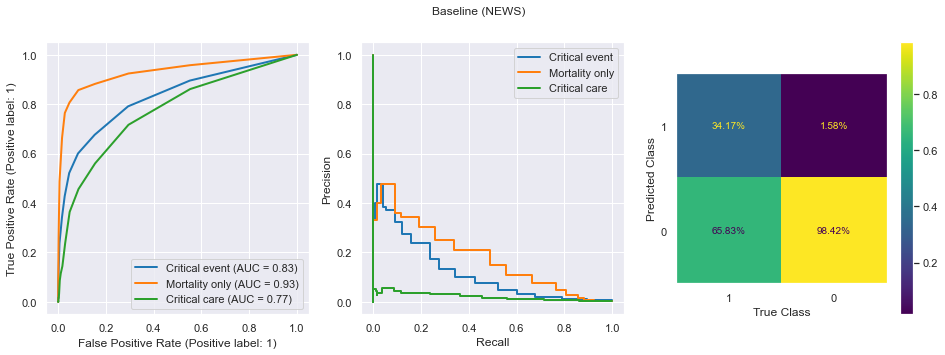

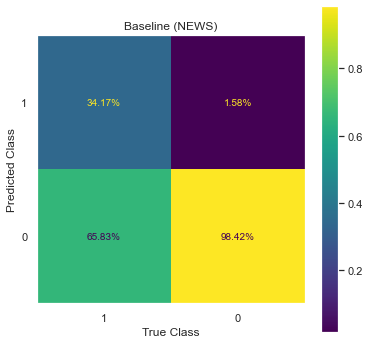

In [9]:
benchmark(
    (sci_test.NEWS_score >= 7).to_numpy(),
    sci_test.NEWS_score.to_numpy(),
    None,
    "Baseline (NEWS)",
    "news",
    tuning=False,
)


## Logistic Regression (NEWS only)

In [10]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

lr_news_params = {
    'LR__max_iter': 1000,
    'LR__random_state': 42,
    'LR__penalty': 'l2',
    'LR__solver': 'lbfgs',
    'LR__C': 6.25,
    'LR__class_weight': 'balanced',
    'IMB__sampling_strategy': 0.15
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_news_params.update(
        tune_logisticregression(
            X_train_news,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "NEWS Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_news_params)
    .fit(X_train_news, y_train)
)
Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 3.2434048595816174, 'LR__class_weight': None, 'IMB__sampling_strategy': 0.4862361784915701}


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
NEWS Logistic Regression,,,,,,,
Critical event,0.905236,0.046328,0.633094,0.086338,0.179190,0.840206,0.840 (0.811-0.867)
Mortality only,0.905312,0.025796,0.823529,0.050026,0.114620,0.927208,0.927 (0.895-0.955)
Critical care,0.903582,0.023954,0.526012,0.045821,0.101314,0.789565,0.790 (0.749-0.827)


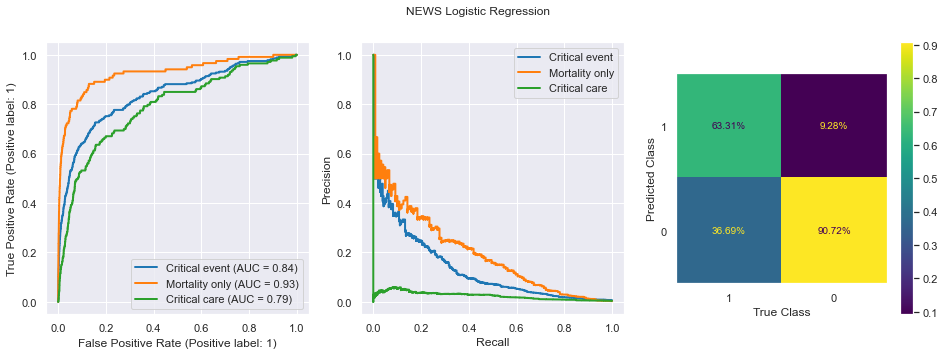

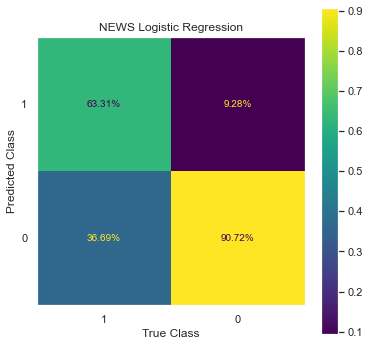

In [11]:
benchmark(
    model.predict(X_test_news.to_numpy()),
    model.predict_proba(X_test_news.to_numpy())[:, 1],
    X_train_news,
    modelkey,
    "news_regression",
    tuning=False,
)



Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

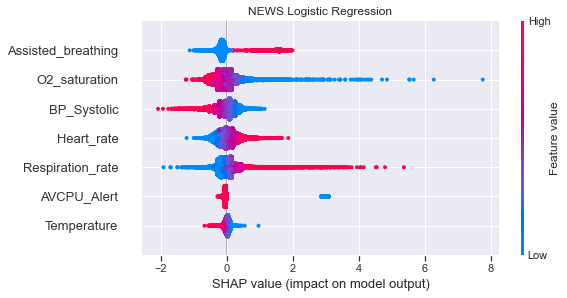

In [12]:
explainer = shap.LinearExplainer(
    model["LR"], X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_news_regression.png", bbox_inches="tight"
    )


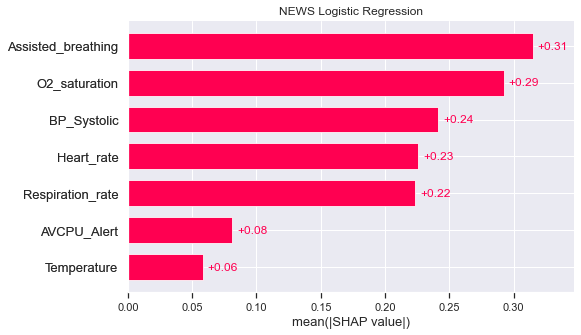

In [13]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_news_regression.png", bbox_inches="tight"
    )


## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

lr_params = {
    'LR__max_iter': 10000,
    'LR__random_state': 42,
    'LR__penalty': 'l2',
    'LR__solver': 'lbfgs',
    'LR__C': 3.6,
    'LR__class_weight': 'balanced',
    'IMB__sampling_strategy': 0.23
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train, y_train)
)
Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 3.7392450803724446, 'LR__class_weight': 'balanced', 'IMB__sampling_strategy': 0.3926774526979135}


<AxesSubplot:>

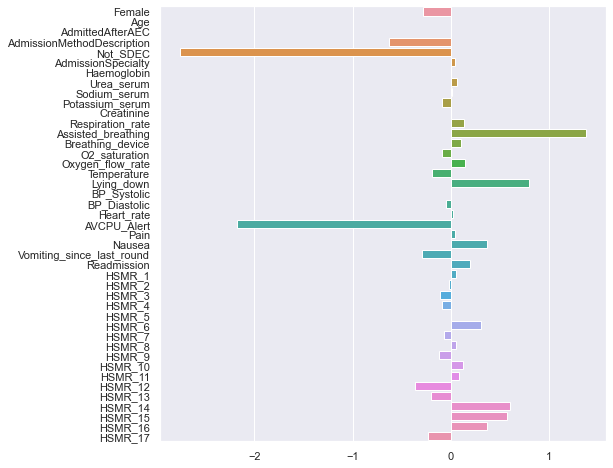

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x=model['LR'].coef_[0], y=X_train.columns, ax=ax)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression,,,,,,,
Critical event,0.854712,0.039810,0.845324,0.076039,0.167498,0.908415,0.908 (0.886-0.929)
Mortality only,0.851989,0.017279,0.857143,0.033876,0.079950,0.910321,0.910 (0.876-0.941)
Critical care,0.852905,0.024903,0.849711,0.048387,0.111448,0.910558,0.911 (0.881-0.936)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression (tuned),,,,,,,
Critical event,0.846215,0.037827,0.848921,0.072426,0.160522,0.908415,0.908 (0.886-0.929)
Mortality only,0.843442,0.016349,0.857143,0.032086,0.075949,0.910321,0.910 (0.876-0.941)
Critical care,0.844408,0.023722,0.855491,0.046163,0.106767,0.910558,0.911 (0.881-0.936)


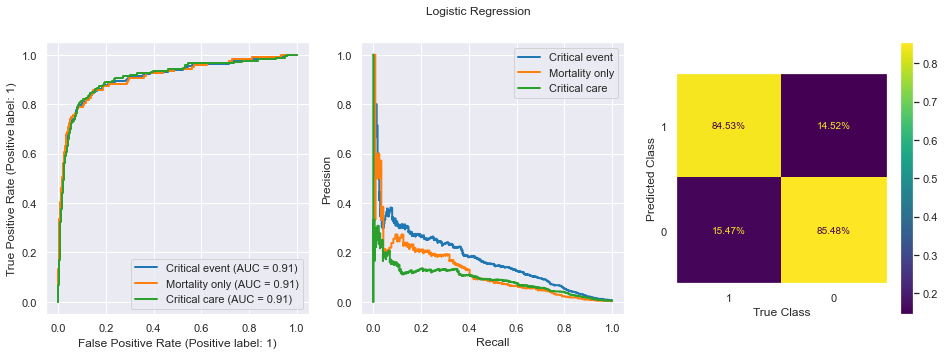

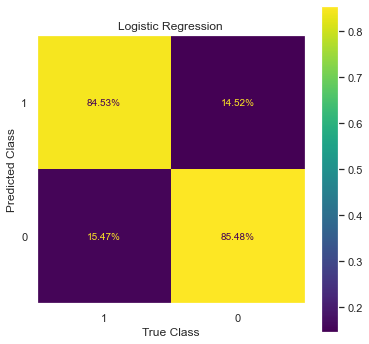

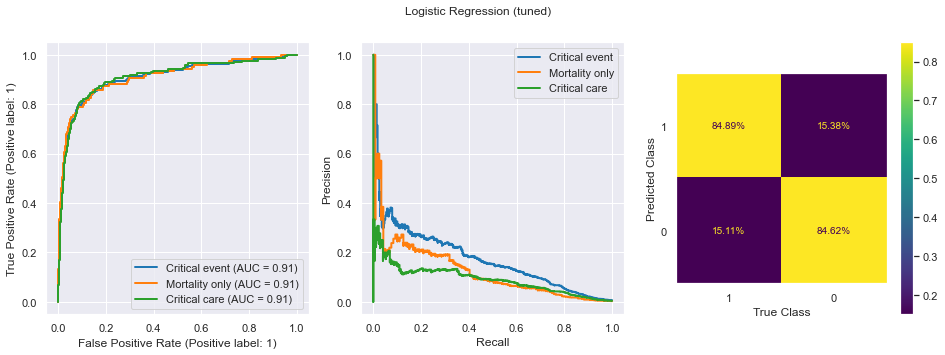

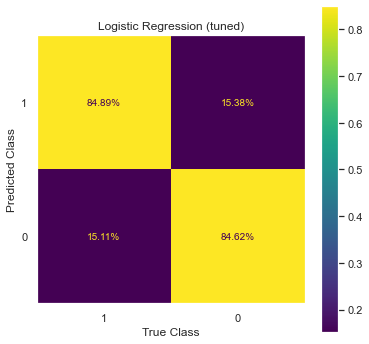

In [16]:
benchmark(
    model.predict(X_test.to_numpy()),
    model.predict_proba(X_test.to_numpy())[:, 1],
    X_test,
    modelkey,
    "logistic_regression",
    tuning=True,
)



Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

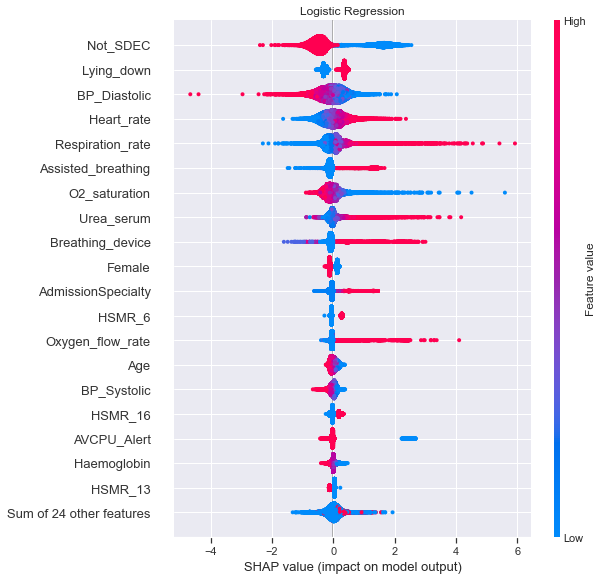

In [17]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


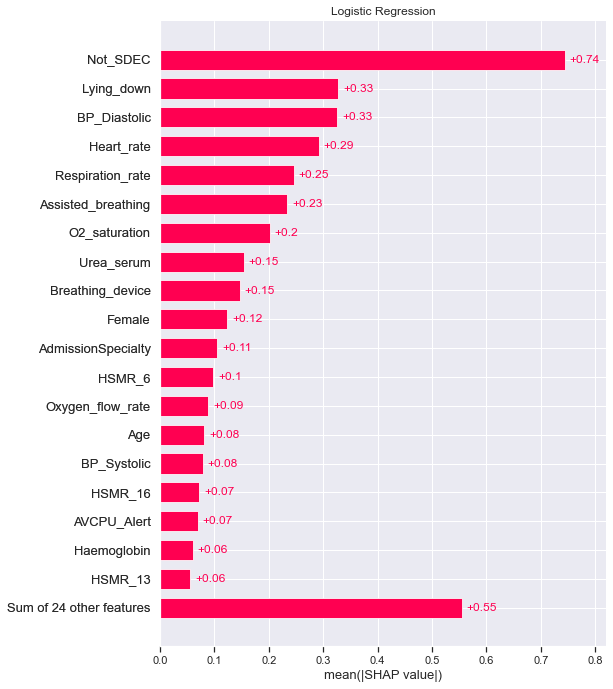

In [18]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logsitic_regression.png", bbox_inches="tight"
    )


## LightGBM

In [19]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

lgbm_params = {
    'LGBM__objective': 'binary',
    'LGBM__verbose_eval': -1,
    'LGBM__random_state': 42,
    'LGBM__metrics': ['l2', 'auc'],
    'LGBM__boosting_type': 'gbdt',
    'LGBM__is_unbalance': True,
    'LGBM__n_jobs': 1,
    'LGBM__feature_pre_filter': False,
    'LGBM__lambda_l1': 0.52,
    'LGBM__lambda_l2': 2.95,
    'LGBM__num_leaves': 250,
    'LGBM__feature_fraction': 0.59,
    'LGBM__bagging_fraction': 0.94,
    'LGBM__bagging_freq': 5,
    'LGBM__min_child_samples': 41,
    'IMB__sampling_strategy': 0.10
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lgbm,
            y_train,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS
        )
    )

modelkey = "LightGBM"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier()),])
    .set_params(**lgbm_params)
    .fit(
        X_train_lgbm,
        y_train,
        LGBM__categorical_feature=categorical_cols_idx,
        LGBM__feature_name=list(X_train.columns),
    )
)

Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'LGBM__lambda_l1': 0.0014568507795955502, 'LGBM__lambda_l2': 9.70050758581473, 'LGBM__num_leaves': 7, 'LGBM__feature_fraction': 0.5796579467880713, 'LGBM__bagging_fraction': 0.8896701090968252, 'LGBM__bagging_freq': 2, 'LGBM__min_child_samples': 82, 'IMB__sampling_strategy': 0.1087894268953578}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.5796579467880713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5796579467880713
[LightGBM] [Warning] bagging_fraction is set=0.8896701090968252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8896701090968252
[LightGBM] [Warning] lambda_l1 is set=0.0014568507795955502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014568507795955502
[LightGBM] [Warning] lambda_l2 is set=9.70050758581473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.70050758581473
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 wil

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM,,,,,,,
Critical event,0.906024,0.059112,0.823741,0.110308,0.229643,0.930366,0.930 (0.914-0.946)
Mortality only,0.903607,0.026329,0.857143,0.051089,0.117241,0.935443,0.935 (0.908-0.960)
Critical care,0.904218,0.036396,0.815029,0.069681,0.154402,0.929346,0.929 (0.910-0.947)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM (tuned),,,,,,,
Critical event,0.879058,0.047696,0.848921,0.090318,0.194719,0.930366,0.930 (0.914-0.946)
Mortality only,0.876336,0.020816,0.865546,0.040655,0.094948,0.935443,0.935 (0.908-0.960)
Critical care,0.877201,0.029709,0.849711,0.057411,0.130319,0.929346,0.929 (0.910-0.947)


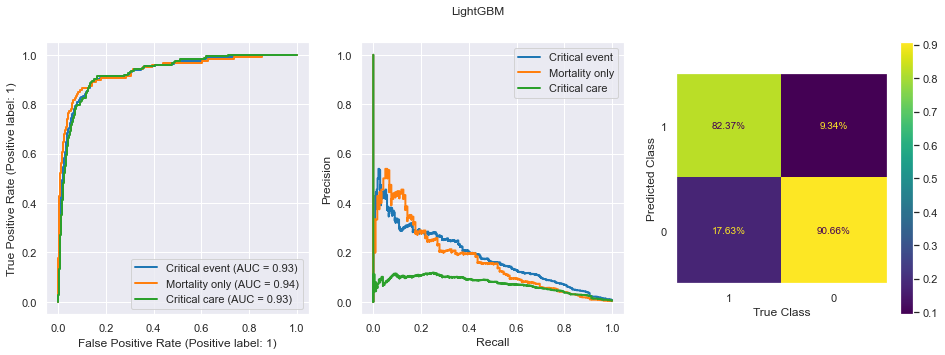

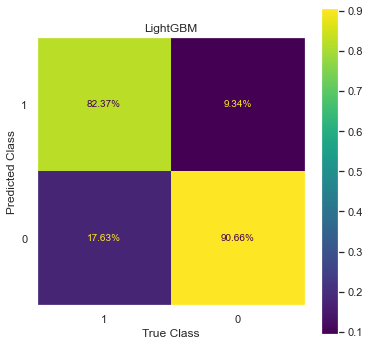

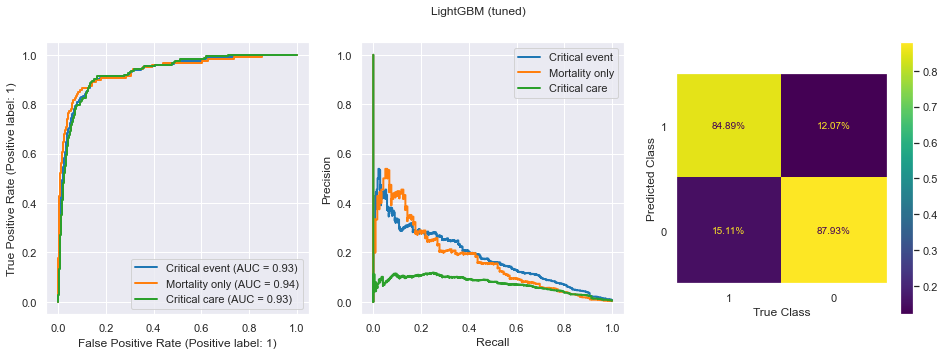

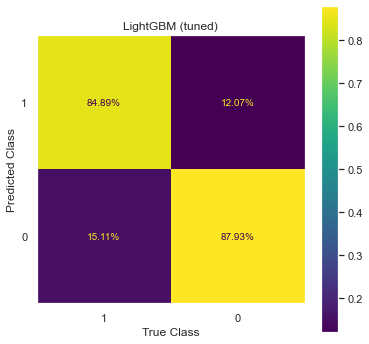

In [20]:
benchmark(
    model.predict(X_test_lgbm),
    model.predict_proba(X_test_lgbm)[:, 1],
    X_test_lgbm,
    modelkey,
    "lightgbm",
    tuning=True,
)



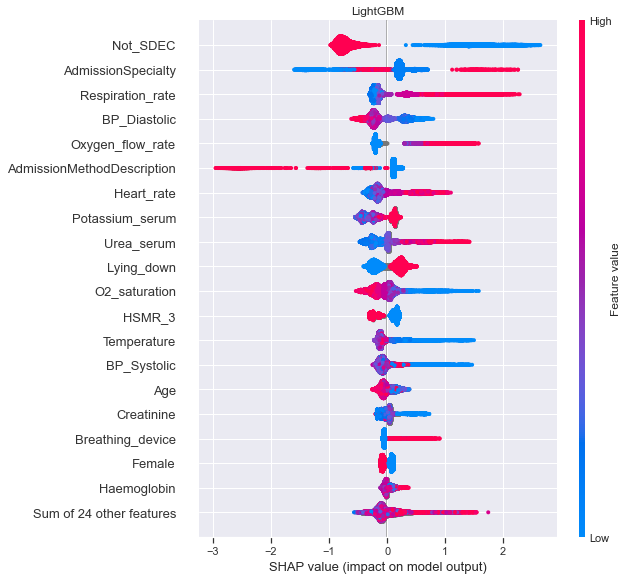

In [21]:
explainer = shap.TreeExplainer(model["LGBM"])
shap_values = explainer(X_test_lgbm)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


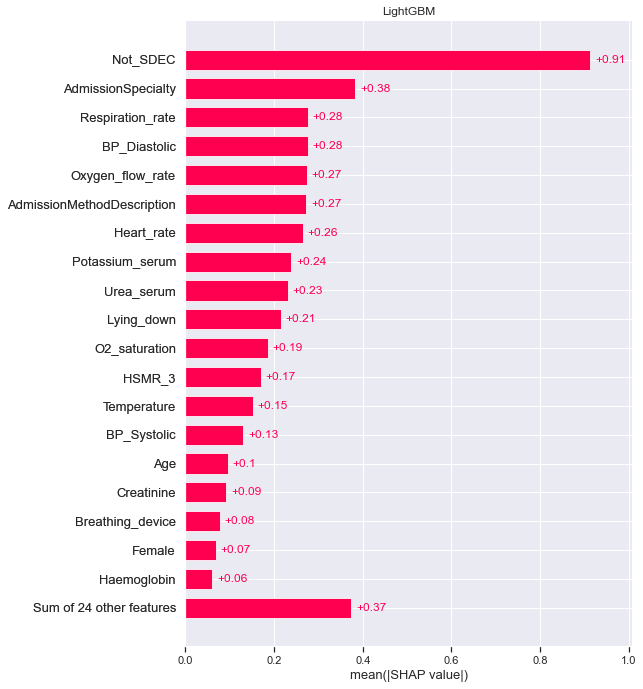

In [22]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


# Comparisons

In [23]:
Notebook.Y_PREDS = dict(reversed(Notebook.Y_PREDS.items()))

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,,,,,,,
LightGBM (tuned),0.879058,0.047696,0.848921,0.090318,0.194719,0.930366,0.930 (0.914-0.946)
Logistic Regression (tuned),0.846215,0.037827,0.848921,0.072426,0.160522,0.908415,0.908 (0.886-0.929)
NEWS Logistic Regression,0.905236,0.046328,0.633094,0.086338,0.179190,0.840206,0.840 (0.811-0.867)
Baseline (NEWS),0.979622,0.133240,0.341727,0.191726,0.260274,0.828473,0.828 (0.799-0.857)


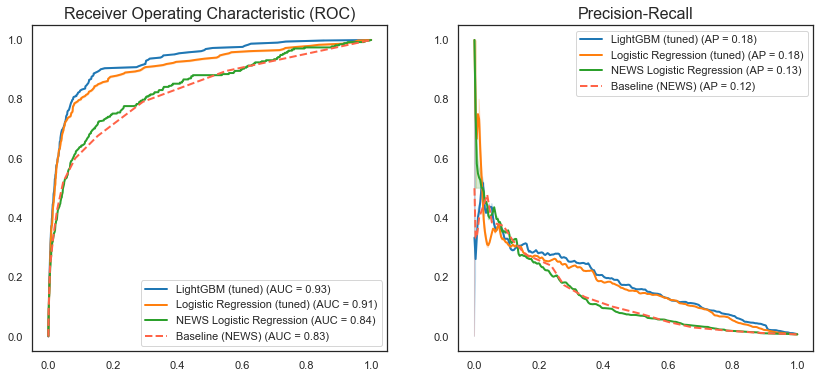

In [24]:
from utils.evaluation import evaluate_multiple

evaluate_multiple(
    y_test,
    Notebook.Y_PREDS,
    news_modelkey="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_curves.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



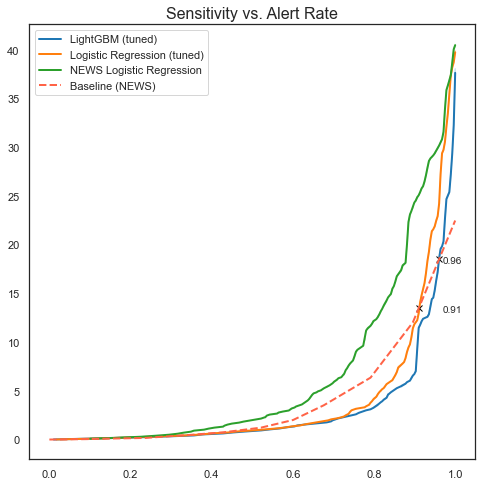

In [25]:
plot_alert_rate({
    modelkey:preds[1] for modelkey, preds in Notebook.Y_PREDS.items()
}, y_test, test_set_n_days, intercept='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/alert_rate.png' if Notebook.SAVE_IMAGES else None)

## SHAP

In [26]:
def patient_force_plots(patient):
    # Must pass NUMERICAL idx for iloc
    patient_data = X_test_cat.iloc[patient].apply(
        lambda x: f"{x:.2f}" if type(x) == np.float64 else x
    )

    explanations = {
        modelkey: shap_values[patient]
        for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
        if not modelkey in ["Baseline (NEWS)"]
    }
    for _ in explanations.keys():
        if len(explanations[_].shape) > 1:
            explanations[_] = explanations[_][:, 1]

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():
        patient_to_use = patient_data if modelkey != "NEWS Logistic Regression" else patient_data[SCICols.news_data_raw]

        explanation = shap.Explanation(explanation)
        explanation.data = patient_to_use.values

        fig = shap.plots.force(
            explanation,
            feature_names=patient_to_use.index,
            matplotlib=True,
            contribution_threshold=0.08,
            show=False,
            text_rotation=15,
        )

        plt.title(modelkey)
        display(fig)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
                bbox_inches="tight",
            )

        plt.clf()

    sns.set_style("darkgrid")



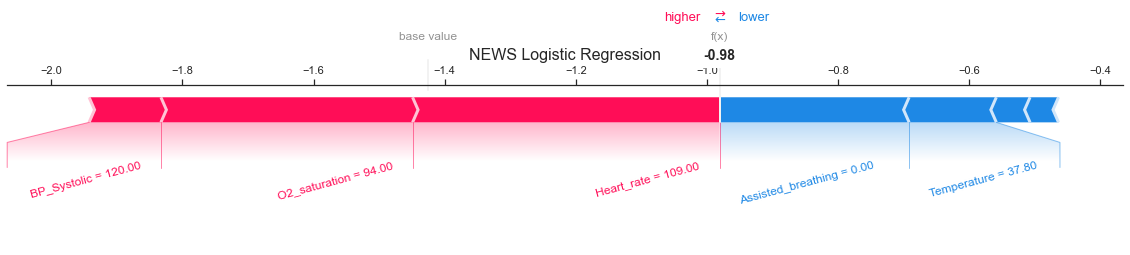

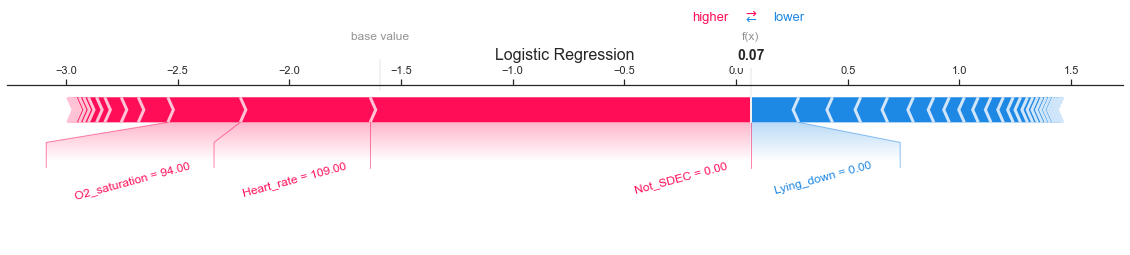

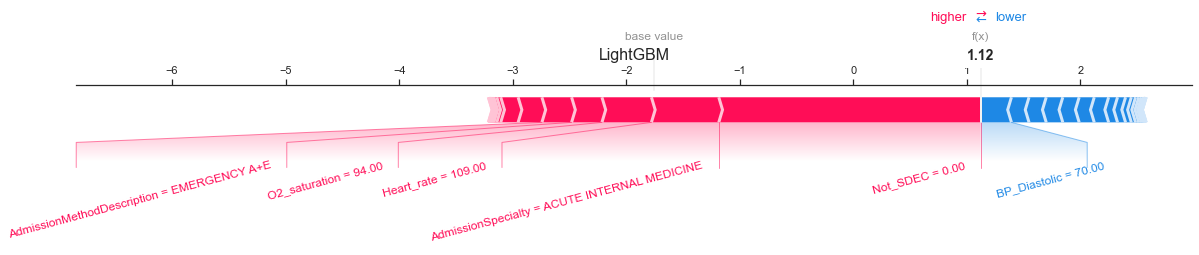

403


<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

In [30]:
preds_df = pd.DataFrame({key:val[0] for key, val in Notebook.Y_PREDS.items()}).astype(bool)
candidates = preds_df[preds_df['LightGBM (tuned)'] & ~preds_df['Baseline (NEWS)'] & y_test].index
patient_force_plots(candidates[0])
print(candidates[0])

In [31]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

In [ ]:
X_test_lgbm_imp = imp.fit_transform(X_test_lgbm)

In [40]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

lr_params = {
    'LR__max_iter': 10000,
    'LR__random_state': 42,
    'LR__penalty': 'l2',
    'LR__solver': 'lbfgs',
    'LR__C': 3.6,
    'LR__class_weight': 'balanced',
    'IMB__sampling_strategy': 0.23
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train_lgbm_imp, y_train)
)


KeyboardInterrupt: 

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM,,,,,,,
Critical event,0.958049,0.108509,0.683453,0.187284,0.331820,0.921557,0.922 (0.904-0.940)
Mortality only,0.957057,0.051970,0.764706,0.097326,0.204311,0.932850,0.933 (0.905-0.961)
Critical care,0.956701,0.063392,0.641618,0.115385,0.227180,0.916802,0.917 (0.897-0.938)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM (tuned),,,,,,,
Critical event,0.858909,0.041115,0.848921,0.078431,0.172212,0.921557,0.922 (0.904-0.940)
Mortality only,0.856340,0.018467,0.890756,0.036184,0.085264,0.932850,0.933 (0.905-0.961)
Critical care,0.856899,0.025087,0.832370,0.048706,0.111940,0.916802,0.917 (0.897-0.938)


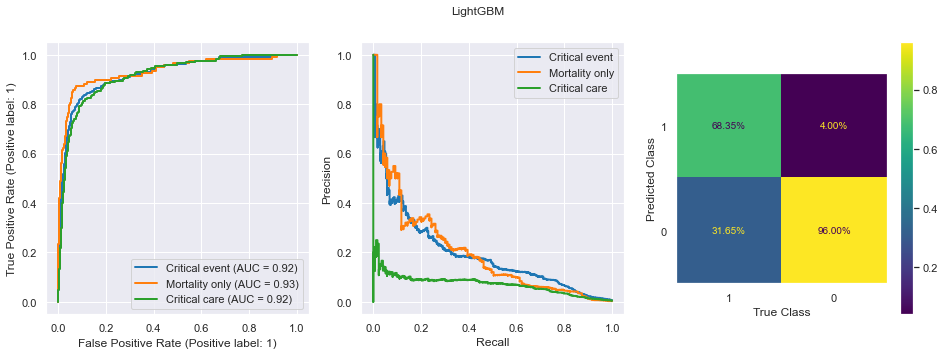

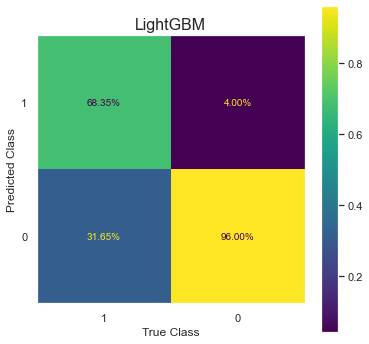

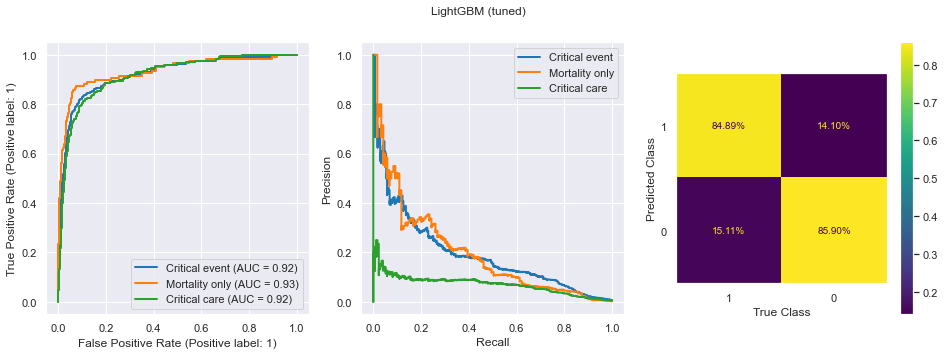

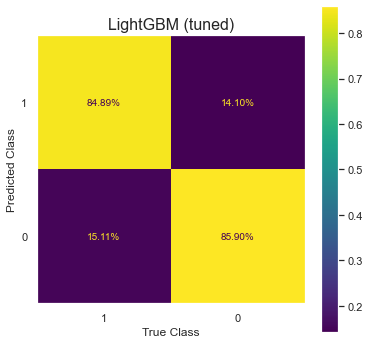

In [ ]:
benchmark(
    model.predict(X_test_lgbm_imp),
    model.predict_proba(X_test_lgbm_imp)[:, 1],
    X_test_lgbm_imp,
    modelkey,
    "lightgbm",
    tuning=True,
)

